In [1]:
# self-define function
from data_cleaning import cleaning_text, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_MDQA"

# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string

import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import spacy 
nlp = spacy.load("en_core_web_lg")

from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the folders and files

In [2]:
# all files path
company_paths = []
sectors = os.listdir(path) 
if '.DS_Store' in sectors:
    sectors.remove('.DS_Store')

for sector in sectors:
    # path to each sector files
    sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path)
    if '.DS_Store' in companies:
        companies.remove('.DS_Store')
    
    for company in companies:
        tmp = sector_path+"/"+company
        company_paths.append(tmp)

Concat the text to one dataframe

In [3]:
# ################################## checking with DF (not necessary) ###################################
# company_paticipants_df = pd.DataFrame()
# other_paticipants_df = pd.DataFrame()
# ########################################################################################################

df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index']) # create a dataframe with 2500 rows 
company_paticipants_list = [] 
other_paticipants_list = []

for single_path in company_paths:
    files = os.listdir(single_path)
    for file in files:
        # print(file)
        if file.endswith(".pdf"):
            # print(file)
            # Load PDF
            with open(single_path+"/"+file, "rb") as f:
                pdf = pdftotext.PDF(f)
            # Save all text to a txt file.
            with open(text_save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
                f.write("\n\n".join(pdf))
            # open the text file
            with open(text_save_path+"/"+file.replace(".pdf", ".txt")) as f:
                content_list = f.readlines()
                # remove the '"' inside the text
                content_list = [re.sub(r'[\n]', '', x) for x in content_list]
                content_list = [re.sub(r'["]', '', x) for x in content_list]
                content_list = [re.sub(r'[\x0c]', '', x) for x in content_list]

                # make each row as a sentence
                contents = pd.DataFrame(content_list)
                # use astype to convert to string
                contents = contents.astype(str)
                contents[0] = contents[0].str.replace('"','')

                df_clean = cleaning_text(contents)  ##### ------> here we use the function from data_cleaning.py
                
                # extract the participants
                tmp_df_text,tmp_company_paticipants,tmp_other_paticipants = participants_list(df_clean) ##### ------> here we use the function from participant_function.py
                company_paticipants_list.append(tmp_company_paticipants)
                other_paticipants_list.append(tmp_other_paticipants)                   

                index_presentation = tmp_df_text[tmp_df_text[0] == 'Presentation'].index
                if len(index_presentation) == 2:
                    tmp_df_text.loc[index_presentation[0], 0] = 'heading' # replace the first index_presentation in df_clean with "head" ##### ------> interacting with the participant_function.py
                

                # ################################## checking with DF (not necessary) ###################################
                # company_paticipants = pd.DataFrame(company_paticipants)
                # if company_paticipants.empty:
                #     company_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # company_paticipants_df[f"{files[files.index(file)]}"] = company_paticipants
                # other_paticipants = pd.DataFrame(other_paticipants)
                # if other_paticipants.empty:
                #     other_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # other_paticipants_df[f"{files[files.index(file)]}"] = other_paticipants
                # ########################################################################################################
                
                df = pd.DataFrame()
                df[f"{files[files.index(file)]}"] = tmp_df_text
                # remove the row using re, if the row ends with Presentation  Investor Day	
                df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
df_clean_na.head(5)
# error_file: '/Users/timliu/Documents/GitHub/BoE_ARP_model/meeting_transcript/Other Insurers/SANPO FH/20180808_Sampo_Oyj-_Earnings_Call_2018-8-8_DN000000002453826008.pdf'

/Users/timliu/Desktop/BoE_ARP_tpqa25/data_cleaning.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('*','')
/Users/timliu/Desktop/BoE_ARP_tpqa25/data_cleaning.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('[','')
/Users/timliu/Desktop/BoE_ARP_tpqa25/data_cleaning.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace(']','')
/Users/timliu/Desktop/BoE_ARP_tpqa25/data_cleaning.py:20: FutureWarning: The default value of regex will change 

Clean the participants list and get all, company, and other participants list

In [ ]:
# generating all the participants
company_paticipants_list = clean_participants_list(company_paticipants_list)
other_paticipants_list = clean_participants_list(other_paticipants_list)
all_participants_list_tmp = []
all_participants_list_tmp = company_paticipants_list + other_paticipants_list

# drop the duplicates
all_participants_list = []
for x in all_participants_list_tmp:
    if x not in all_participants_list:
        all_participants_list.append(x)


Add two columns which include participants and the index of the participant (to be used for merging as paragraph)

In [ ]:
concat_df = pd.DataFrame()
participants_index =pd.DataFrame(np.zeros((2500,1)), columns=['index'])
for column in df_clean_na.columns:
    # identify all the rows in df with all_participants_list in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants_list)].index.tolist()
    # apply the both_participants_row_index to the df_clean_na['participants']
    concat_df[column] = df_clean_na[column]
    ppt_list = df_clean_na[column].apply(lambda x: x if x in all_participants_list else 0)
    idx_list = [int(idx) if ppt_list[idx] != 0 else np.nan for idx in range(len(ppt_list)) ]
    # adding paricipants name
    concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
    # adding index columns
    concat_df[f"idx_{column}"] = idx_list
    # fill the NaN with the value of the previous row
    concat_df[f"participants_{column}"] = concat_df[f"participants_{column}"].fillna(method='ffill')
    concat_df[f"idx_{column}"] = concat_df[f"idx_{column}"].fillna(method='ffill')

concat_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/3263364826.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/3263364826.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"idx_{column}"] = idx_list
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/3263364826.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usual

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,participants_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,idx_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,participants_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,idx_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,participants_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,idx_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,...,idx_20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,participants_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,idx_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,participants_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,idx_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,participants_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,idx_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Presentation,NaN,NaN,Presentation,NaN,NaN,Presentation,NaN,NaN,Presentation,...,NaN,Presentation,NaN,NaN,Presentation,NaN,NaN,Presentation,NaN,NaN
1,Paul Feeney,Paul Feeney,1.0,Paul Feeney,Paul Feeney,1.0,Paul Feeney,Paul Feeney,1.0,Paul Feeney,...,1.0,Operator,Operator,1.0,Operator,Operator,1.0,Operator,Operator,1.0
2,17570862,Paul Feeney,1.0,17570862,Paul Feeney,1.0,17570862,Paul Feeney,1.0,17570862,...,1.0,"Good day, everyone. Welcome to the Everest Re ...",Operator,1.0,Good day everyone and welcome to the Everest R...,Operator,1.0,"Good day, everyone. Welcome to the Second Quar...",Operator,1.0
3,Good morning everybody. Welcome to our First F...,Paul Feeney,1.0,"Hello, and good morning, everyone. Thank you f...",Paul Feeney,1.0,"Good morning, everybody. We'll follow the usua...",Paul Feeney,1.0,"Good morning, everyone. And you'll understand ...",...,1.0,earnings release call. Today's conference is b...,Operator,1.0,earnings conference release call.,Operator,1.0,Group. Today's conference is being recorded. A...,Operator,1.0
4,"know, we announced the CFO transition back in ...",Paul Feeney,1.0,for our Interim Results Presentation. Hopefull...,Paul Feeney,1.0,summary of 2019 and I'll spend a bit of time o...,Paul Feeney,1.0,today. But the broad format is similar to what...,...,1.0,"remarks and introductions, I would like to tur...",Operator,1.0,Operator Instructions,Operator,1.0,"introductions, I would like to turn the confer...",Operator,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,Paul Feeney,624.0,NaN,Paul Feeney,761.0,NaN,Paul Feeney,730.0,NaN,...,811.0,NaN,Operator,642.0,NaN,Operator,734.0,NaN,Operator,652.0
2496,NaN,Paul Feeney,624.0,NaN,Paul Feeney,761.0,NaN,Paul Feeney,730.0,NaN,...,811.0,NaN,Operator,642.0,NaN,Operator,734.0,NaN,Operator,652.0
2497,NaN,Paul Feeney,624.0,NaN,Paul Feeney,761.0,NaN,Paul Feeney,730.0,NaN,...,811.0,NaN,Operator,642.0,NaN,Operator,734.0,NaN,Operator,652.0
2498,NaN,Paul Feeney,624.0,NaN,Paul Feeney,761.0,NaN,Paul Feeney,730.0,NaN,...,811.0,NaN,Operator,642.0,NaN,Operator,734.0,NaN,Operator,652.0


make the dataframe as horizontal instead of vertical, and get the company_paticipants_yes and other_paticipants_yes

In [ ]:
model_df = pd.DataFrame()
for i in range(int(len(concat_df.columns.to_list())/3)):
    #print(i)
    tmp_df = pd.DataFrame()
    tmp_df = concat_df.iloc[:,(i*3):(i*3)+3].copy()
    # extract the index as column from the text
    tmp_df['file_name'] = tmp_df.columns.to_list()[0]
    # extract the date from the index column
    tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
    # change the date column to datetime
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    # rename to be consistent with the column name
    tmp_df.columns = ["line", "participants",  "idx", "file_name","date"]
    # if the 'participants' column's value equals to any of the company_paticipants_list, other_paticipants_list, then set the value to 0
    tmp_df['company_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in company_paticipants_list else 0)
    tmp_df['other_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in other_paticipants_list else 0)
    # drop the row if the column "line" is NaN
    tmp_df = tmp_df.dropna(subset=['line'], how='all')
    tmp_df['company_name1']  = tmp_df['file_name'].apply(lambda x: x.split('_')[1])
    tmp_df['company_name2']  = tmp_df['file_name'].apply(lambda x: x.split('_')[2])
    tmp_df['company_name'] = tmp_df["company_name1"] + " " + tmp_df["company_name2"]
    # drop the 'company_name1' and 'company_name2' column
    tmp_df = tmp_df.drop(columns=['company_name1', 'company_name2']).reset_index(drop=True)
    # drop line contains only participants name
    id_rows = tmp_df[tmp_df['line']==tmp_df['participants']].index
    tmp_df = tmp_df.drop(id_rows)
    # append into dataframe
    model_df = model_df.append(tmp_df)

# drop the Nan rows (no participants and idx, which are not what we want)
model_df = model_df.dropna(subset=['participants','idx'], how='all')
model_df

,line,participants,idx,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name
2,17570862,Paul Feeney,1.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
3,Good morning everybody. Welcome to our First F...,Paul Feeney,1.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
4,"know, we announced the CFO transition back in ...",Paul Feeney,1.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
5,Tim Tookey. So you'll hear from both of them t...,Paul Feeney,1.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
6,"financials, and Mark will go through our optim...",Paul Feeney,1.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
...,...,...,...,...,...,...,...,...
647,This does conclude today's question-and-answer...,Operator,646.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
648,back over to management for any closing or add...,Operator,646.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
650,19732216,Beth Farrell,649.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,0,Everest Re
651,I would just like to thank everybody for joini...,Beth Farrell,649.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,0,Everest Re


Use the idx to merge the participants and the text, the model_df will represent with paragraph and the other details

In [ ]:
# model_df groupby 'participants','file_name','date','company_paticipants_yes','other_paticipants_yes','company_name' with ['sentence'] and .apply(' '.join)
model_df = model_df.groupby(['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name'])['line'].apply(' '.join).reset_index()
# model_df rename the column 'sentence' to 'paraghrph'
model_df.columns = ['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name','paraghrph']
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,13.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor..."
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,18.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In..."
2,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,834.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good..."
3,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,6.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen...."
4,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,83.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L..."
...,...,...,...,...,...,...,...,...
141416,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1719.0,1,0,NN Group,"1432061 16332540 Yes, Mr. Chair. As the Su..."
141417,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1790.0,1,0,NN Group,"16332540 Ladies and gentlemen, based on the ..."
141418,Zack Perry,20160429_FAIRFAX_FINL_HLD-_Earnings_Call_2016-...,2016-04-29,478.0,0,1,FAIRFAX FINL,"21697762 Yeah, good morning. Thanks for taki..."
141419,Zak Smerczak,20140507_LEGAL_-_GEN_GRP-_Sales_Results_Call_2...,2014-05-07,484.0,0,1,LEGAL -,17189389 My question's been answered. Thanks.


# Remove the participants and post_clean

In [ ]:
def clean_tokens(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # # step 2: change the list to lower case
    # text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

Remove the name in the text

In [ ]:
def participants_tokens(all_participants_list):
    # all_participants_list list to dataframe
    tmp_df = pd.DataFrame(all_participants_list)
    # test replace the dot with ""
    tmp_df[0] = tmp_df[0].str.replace('.','')
    # apply the clean_tokens function to the tmp_df dataframe
    tmp_participants_tokens = clean_tokens(tmp_df[0])
    # append all the tokens to list
    participants_tokens = []
    for i in tmp_participants_tokens:
        participants_tokens.extend(i)
    return participants_tokens

participants_tokens = participants_tokens(all_participants_list)
# participants_tokens remove the vlaue that the len is less than 3
participants_tokens = [i for i in participants_tokens if len(i)>2]
# participants_tokens

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/3219497472.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp_df[0] = tmp_df[0].str.replace('.','')
100%|██████████| 2735/2735 [00:08<00:00, 323.56it/s]


In [ ]:
def post_process(df):
    # create a new column 'paraghrph_clean'
    df['paraghrph_clean'] = df['paraghrph']
    # remove the participants name from 'paraghrph' if exist in participants_tokens
    for i in participants_tokens:
        df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(i,'')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(',','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(')','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(through translator)','')

    return df

model_df = post_process(model_df)

pd.set_option('display.max_columns', None)
print(model_df['file_name'].nunique())
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/4063045589.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/4063045589.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/4063045589.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrp

1989


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,13.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,18.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...
2,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,834.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...
3,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,6.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...
4,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,83.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L...",Thank you Lard and good morning everyone Let m...
...,...,...,...,...,...,...,...,...,...
141416,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1719.0,1,0,NN Group,"1432061 16332540 Yes, Mr. Chair. As the Su...",1432061 16332540 Yes Mr Chair As the Super...
141417,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1790.0,1,0,NN Group,"16332540 Ladies and gentlemen, based on the ...",16332540 Ladies and gentlemen based on the a...
141418,Zack Perry,20160429_FAIRFAX_FINL_HLD-_Earnings_Call_2016-...,2016-04-29,478.0,0,1,FAIRFAX FINL,"21697762 Yeah, good morning. Thanks for taki...",21697762 Yeah good morning Thanks for taking...
141419,Zak Smerczak,20140507_LEGAL_-_GEN_GRP-_Sales_Results_Call_2...,2014-05-07,484.0,0,1,LEGAL -,17189389 My question's been answered. Thanks.,17189389 My question's been answered Thanks


Remove the numeric values

In [ ]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')
model_df['paraghrph_clean']= model_df['paraghrph_clean'].astype(str)

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/2780780902.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')


In [ ]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatization(texts, allowed_postags=["NOUN"]):
    doc = nlp(texts)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return (final) # 

# use apply the lemmatization function to the tmp_df dataframe
model_df['paraghrph_noun'] = model_df['paraghrph_clean'].apply(lemmatization)

model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,13.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,18.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...
2,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,834.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...,floor advertising campaign company board yeste...


# Tokenizing the text

Apply the function to paraghrph_noun and get the token 

In [3]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [ ]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_8911/458752224.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
100%|██████████| 141421/141421 [05:23<00:00, 436.93it/s]


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,13.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...,"[morning, quer, light, result, rating, agency,..."
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,18.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...,"[morning, year, force, bull, development, abil..."
2,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,834.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...,floor advertising campaign company board yeste...,"[floor, advertising, campaign, company, board,..."
3,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,6.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...,morning lady gentleman conference call result ...,"[morning, lady, gentleman, conference, result,..."
4,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,83.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L...",Thank you Lard and good morning everyone Let m...,morning quer operating result % year increase ...,"[morning, quer, operating, result, year, incre..."
...,...,...,...,...,...,...,...,...,...,...,...
141416,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1719.0,1,0,NN Group,"1432061 16332540 Yes, Mr. Chair. As the Su...",Yes Mr Chair As the Supervisory we aim ...,remuneration structure light proposal remunera...,"[remuneration, structure, light, proposal, rem..."
141417,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1790.0,1,0,NN Group,"16332540 Ladies and gentlemen, based on the ...",Ladies and gentlemen based on the active fi...,gentleman financial ph policy institution rati...,"[gentleman, financial, policy, institution, ra..."
141418,Zack Perry,20160429_FAIRFAX_FINL_HLD-_Earnings_Call_2016-...,2016-04-29,478.0,0,1,FAIRFAX FINL,"21697762 Yeah, good morning. Thanks for taki...",Yeah good morning Thanks for taking the que...,morning thank question question gentleman rati...,"[morning, question, question, gentleman, ratio..."
141419,Zak Smerczak,20140507_LEGAL_-_GEN_GRP-_Sales_Results_Call_2...,2014-05-07,484.0,0,1,LEGAL -,17189389 My question's been answered. Thanks.,My question's been answered Thanks,question thank,[question]


# Word-Length Count

In [ ]:
# create column for length analysis outcome
model_df['word_count'] = model_df["token"].apply(lambda x: len(x))
model_df['char_count'] = model_df["token"].apply(lambda x: sum(len(word) for word in x))
model_df['sentence_count']  = model_df['paraghrph'].apply(lambda x: len(str(x).split(".")))
model_df['avg_word_length'] = model_df['char_count'] / model_df['word_count']
model_df['avg_sentence_length'] = model_df['word_count'] / model_df['sentence_count'] # note that the word_count is only with noun tokens
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,13.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...,"[morning, quer, light, result, rating, agency,...",124,837,42,6.750000,2.952381
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,18.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...,"[morning, year, force, bull, development, abil...",260,1760,80,6.769231,3.250000
2,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,834.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...,floor advertising campaign company board yeste...,"[floor, advertising, campaign, company, board,...",33,230,17,6.969697,1.941176


Exclude the rows that the sentence_count is less than 3 (not important to our tp modelling)

In [ ]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

# Drop the duplicates

In [ ]:
len(model_df)
check_dup = model_df.copy()
check_dup['true_false'] = model_df.duplicated(subset=['paraghrph'])
print(check_dup['true_false'].value_counts())
# leave only one row for each paraghrph
model_df = model_df.drop_duplicates(subset=['paraghrph'])
model_df = model_df.reset_index(drop=True)
print(len(model_df))

False    62811
True       335
Name: true_false, dtype: int64
62811


# Load the df so the above we don't have to rerun anagin

In [ ]:
# save the dataframe to csv file
model_df.to_csv('./main_df_output/topic_modelling_MDQA_df.csv', index=False) # careful the file is not saving tokenized data

In [26]:
# # limit the model_df['date'] from 2011-01-01 to 2021-12-31
# model_df['date'] = pd.to_datetime(model_df['date'])
# model_df = model_df[(model_df['date'] >= '2011-01-01') & (model_df['date'] <= '2021-12-31')]
# model_df = model_df.reset_index(drop=True)
# # model_df['date'] to str
# model_df['date'] = model_df['date'].astype(str)

In [4]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/topic_modelling_MDQA_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])

# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# drop the paraghrph_noun if that is not english
model_df[model_df['paraghrph_noun'].str.contains('[a-zA-Z]')]
model_df = model_df.reset_index(drop=True)

# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean

pd.set_option('display.max_columns', None)
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_12418/566633171.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
100%|██████████| 62811/62811 [12:00<00:00, 87.22it/s] 


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,234.0,1,1,Mapfre SA,3878205 Three numbers questions please. The ...,Three numbers questions please The first on...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",21,133,12,6.333333,1.750000
1,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,445.0,1,0,LEGAL -,18966542 Well we bring in to our Group's IGD...,Well we bring in to our 's IGD we bring in ...,surplus negative liability,"[surplus, negative, liability]",3,24,5,8.000000,0.600000
2,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,167.0,0,1,LEGAL -,"4191309 Can I just follow up, just again on ...",Can I just follow up just again on the US? ...,point point equity p process theory equity time,"[point, point, equity, p, process, theory, equ...",7,39,6,5.571429,1.166667
3,Giulia Raffo,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,530.0,1,1,Mapfre SA,7573856 Okay. Thank you very much. Again on ...,Okay Thank you very much Again on the asset...,asset side debt page % saving bank,"[asset, debt, save, bank]",4,17,6,4.250000,0.666667
4,Giulia Raffo,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,456.0,1,1,Mapfre SA,7573856 All right. My second question is on ...,All right My second question is on slide Y...,question slide lot question clarification % as...,"[question, slide, lot, question, clarification...",16,102,8,6.375000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62806,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,637.0,1,0,GJENSIDIGE FORSI-,"19939645 Of the certain extent, at least in ...",Of the certain extent at least in Scandinav...,extent product house car reaction increase cov...,"[extent, product, house, car, reaction, increa...",26,149,6,5.730769,4.333333
62807,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,532.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. We are -- we have a large claim...,Yes We are -- we have a large claims organi...,claim organization agreement dialogue supprs c...,"[claim, organization, agreement, dialogue, sup...",25,159,7,6.360000,3.571429
62808,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,407.0,1,0,GJENSIDIGE FORSI-,5865247 We have demonstrated since 2018 that...,We have demonstrated since that we have en...,ping power track motor increase % ability clai...,"[ping, power, track, motor, increase, ability,...",27,176,9,6.518519,3.000000
62809,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,688.0,1,0,GJENSIDIGE FORSI-,19939645 The second question on the home sel...,The second question on the home seller mar...,question home seller market product year stand...,"[question, seller, market, product, year, stan...",51,296,11,5.803922,4.636364


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


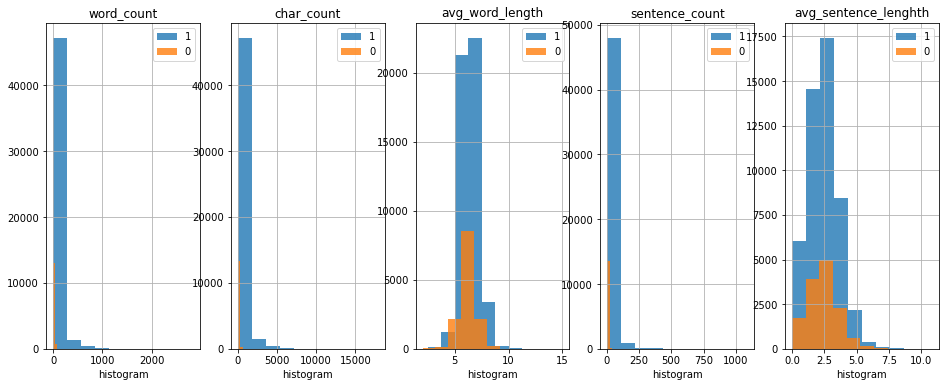

In [5]:
# visualize the distribution of the dataset
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "company_paticipants_yes"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in model_df[y].unique():
    sns.distplot(model_df[model_df[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(model_df[model_df[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(model_df[model_df[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(model_df[model_df[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(model_df[model_df[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(model_df[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(model_df[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(model_df[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(model_df[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(model_df[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

high frequency words excluding

In [6]:
# drop the word that's too general
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i not in [
    'afternoon', 'morning', 'conference','today','lady', 'gentleman', 'presentation',
    'question','answer', 'slide',
    # 'proÔ¨Åt', 'eÔ¨Äect','proÔ¨Åtability','oÔ¨Ä','diÔ¨Äerent','eÔ¨Éciency','Ô¨Ågure','inÔ¨Çation','Ô¨Çow','conÔ¨Åt',
    'mm', 'mm_mm','guy','sir',' ','ytd','host_sir','bb','ty','word', 'year', 'quer','month','period', 'day', 'time','result', 'investor','week', 'update',
    # 'Ô¨Åre','diÔ¨Äerence','diÔ¨Écult','beneÔ¨Åt', 
    'business','lot','ratio','rate','quarter', 'number', 'point', 'term', 'thing', 'level', 
    'bit', 'sort', 'reason', 'management', 'fact', 'case', 'area', 'people', 'sense', 'item', 'issue', 'market', 
    'meeting', 'questions','answers', 'managements', 'discussion', 'section', 'presentation'
     ]])
len(model_df)

62811

In [7]:
# drop the token that is only with one character
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if len(i)>1])
# drop the token if that is not english
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i.isalpha()])
len(model_df)

62811

In [8]:
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# # visualize word frequencies
# # figure size
# fig = plt.figure(figsize=(30, 6))
# plt.bar(word_fr.word[0:50], word_fr.freq[0:50], color='green')
# plt.xlabel("Word")
# plt.ylabel("Count")
# plt.title("Word Frequency")
# plt.show()
word_fr.head(20)

,word,freq
0,capital,13481
1,loss,10860
2,growth,10837
3,impact,9410
4,portfolio,8913
5,company,8859
6,change,8577
7,cost,8236
8,increase,8015
9,basis,7735


# 這邊要修正

In [9]:
# remove 150 most frequent words which is known in this context
word_list = word_fr.head(150)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]

model_df['token'] = mdy_list

# recrate again for getting the docs_tokens
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)

In [10]:
len(docs_tokens)

62811

# Regroup to file base

In [ ]:
# test_df = model_df.copy()
# file_list = test_df['file_name'].unique().tolist()
# # if the file_list == test_df['file_name'], append to the file_list
# file_token_list = []
# file_token_df = []
# file_model_df = pd.DataFrame()
# for file in file_list:
#     tmp_df = test_df[test_df['file_name']==file]

#     tmp_token_list = tmp_df['token'].to_list()
#     for i in tmp_token_list:
#         for k in i:
#             file_token_list.append(k)
#     file_model_df.append(file_token_list)
#     dtm_token_list = []
#     dtm_df['year_quater'] = date_list
# dtm_df['token'] = dtm_token_df
# # dtm_df drop the row 45
# dtm_df = dtm_df.drop(45)
# dtm_df = dtm_df.drop(44)
# dtm_df = dtm_df.reset_index(drop=True)
# dtm_df

In [90]:
# model_df sort by the file_name and date and idx
model_df = model_df.sort_values(by=['file_name', 'date', 'idx'])
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
28,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,1.0,1,0,Mapfre SA,"3910673 Good afternoon, ladies and gentlemen...",Good afternoon ladies and gentlemen Welcome...,afternoon lady gentleman year result presentat...,"[overview, financial, standpoint, backdrop, in...",222,1468,81,6.612613,2.740741
34,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,90.0,1,0,Mapfre SA,"4108780 Thank you, Esteban. Good afternoon t...",Thank you Good afternoon to everybody on t...,afternoon internet h slide breakdown premium p...,"[internet, breakdown, turnaround, reconciliati...",334,2283,106,6.835329,3.150943
0,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,234.0,1,1,Mapfre SA,3878205 Three numbers questions please. The ...,Three numbers questions please The first on...,number question one call sense release contrib...,"[debate, phase, nonlife]",21,133,12,6.333333,1.750000
36,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,250.0,1,0,Mapfre SA,"4108780 Good afternoon, James. Let's see. Pr...",Good afternoon Let's see Prior year releas...,afternoon year release figure triangle report ...,"[triangle, report, tomorrow, triangle]",10,74,10,7.400000,1.000000
53,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,261.0,1,0,Mapfre SA,"4108780 Once again, we are not giving the re...",Once again we are not giving the reserve re...,reserve release triangle triangle run off year...,"[triangle, triangle, triangle]",9,65,5,7.222222,1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62796,Faizan Lakhani,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,715.0,0,1,GJENSIDIGE FORSI-,20034558 Thank you for taking my question. I...,Thank you for taking my question I just had...,question question property rate property marke...,[],15,93,7,6.200000,2.142857
62778,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,724.0,1,0,GJENSIDIGE FORSI-,19939645 Company Name Gjensidige Forsikring ...,Name Gjensidige ASA I'll talk to the easy...,easy way fact increase claim inﬂation claim in...,"[easy, inﬂation, inﬂation]",9,56,6,6.222222,1.500000
62779,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,745.0,1,0,GJENSIDIGE FORSI-,"19939645 Private Norway, I think we don't gu...",Private Norway I think we don't guide on ki...,loss ratio ph frequency loss ratio kind volati...,"[eﬀect, eﬃcient, proﬁtability, hindrance]",24,139,6,5.791667,4.000000
62797,Jan Erik Gjerland,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,761.0,0,1,GJENSIDIGE FORSI-,5346031 Thank you. Just one follow-up on the...,Thank you Just one follow-up on the run of ...,follow up run gain level % course quer year so...,"[follow, prediction]",7,37,5,5.285714,1.400000


In [100]:
model_df_file_base = model_df.copy()
model_df_file_base = model_df_file_base[['file_name','date','company_name', 'token', 'paraghrph', 'paraghrph_clean', 'paraghrph_noun']]
# groupby if file_name, date, company_name is the same, then append the token and paraghrph
model_df_file_base_token = model_df_file_base.groupby(['file_name','date','company_name'])['token'].apply(list).reset_index()
model_df_file_base_paraghrph = model_df_file_base.groupby(['file_name','date','company_name'])['paraghrph'].apply(list).reset_index()
model_df_file_base_paraghrph_clean = model_df_file_base.groupby(['file_name','date','company_name'])['paraghrph_clean'].apply(list).reset_index()
model_df_file_base_paraghrph_noun = model_df_file_base.groupby(['file_name','date','company_name'])['paraghrph_noun'].apply(list).reset_index()
# merge model_df_file_base_token and model_df_file_base_paraghrph
model_df_file_base_token_paraghrph = pd.merge(model_df_file_base_token, model_df_file_base_paraghrph, on=['file_name','date','company_name'])



def remove_brackets (x):
    docs_tokens = []
    for i in x:
        for k in i:
            docs_tokens.append(k)
    return docs_tokens

# apply remove_brackets to the model_df_file_base['token']
model_df_file_base_token_paraghrph['token'] = model_df_file_base_token_paraghrph['token'].apply(lambda x: remove_brackets(x))
model_df_file_base_token_paraghrph.head()


,file_name,date,company_name,token,paraghrph
0,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,Mapfre SA,"[overview, financial, standpoint, backdrop, in...","[ 3910673 Good afternoon, ladies and gentleme..."
1,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,LEGAL -,"[restructuring, instruction, land, iver, silve...",[Hello. Welcome to the U.S. capital restructur...
2,20110203_Markel_Corp-_Earnings_Call_2011-2-3_S...,2011-02-03,Markel Corp-,"[picipant, listen, mode, host, poration, privi...",[At this time all participants are in a listen...
3,20110208_Beazley_PLC-_Earnings_Call_2011-2-8_S...,2011-02-08,Beazley PLC-,"[crowd, crowd, crowd, reception, report, seaso...",[ 5697110 So welcome to everybody. The crowd ...
4,20110209_INTACT_FINANCIAL-_Earnings_Call_2011-...,2011-02-09,INTACT FINANCIAL-,"[poration, mute, background, noise, speaker, r...","[Good morning. My name is Stephanie, and I wil..."


In [92]:
# recrate again for getting the docs_tokens
temp_token = model_df_file_base['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)

# topic modeling

In [93]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              
    docs_tokens,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

In [95]:
len(docs_phrased)

62811

In [96]:
# With Tomotopy, it is necessary to wrap the preprocessed documents in a corpus-like object
# create corpus
corpus = tp.utils.Corpus()                   
for item in docs_phrased:                   
    if item != []:
        corpus.add_doc(words=item)
    else:
        corpus.add_doc(words=" ")
print(len(corpus))

62811


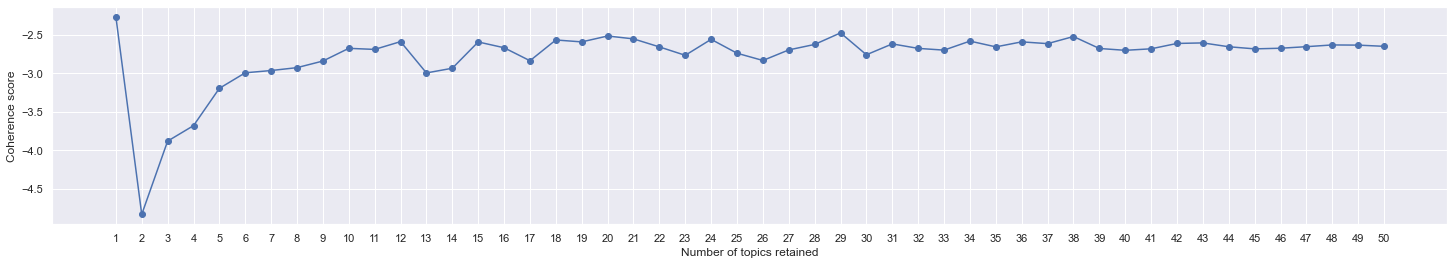

In [97]:
# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 51, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed = 1) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 51, 1))
plt.show()

In [98]:
# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 101, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed = 1) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

KeyboardInterrupt: 

In [25]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=19, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,payment,0.028,0,0
1,travel,0.026,0,1
2,ship,0.023,0,2
3,mail,0.021,0,3
4,panel,0.020,0,4
...,...,...,...,...
5,auto,0.015,18,5
6,net,0.012,18,6
7,decrease,0.010,18,7
8,compensation,0.010,18,8


In [27]:
import pyLDAvis
# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data

prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

In [78]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=19, corpus=corpus_paragraph, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,234.0,1,1,Mapfre SA,3878205 Three numbers questions please. The ...,Three numbers questions please The first on...,number question one call sense release contrib...,"[debate, phase, nonlife]",21,133,12,6.333333,1.750000
1,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,445.0,1,0,LEGAL -,18966542 Well we bring in to our Group's IGD...,Well we bring in to our 's IGD we bring in ...,surplus negative liability,"[surplus, negative]",3,24,5,8.000000,0.600000
2,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,167.0,0,1,LEGAL -,"4191309 Can I just follow up, just again on ...",Can I just follow up just again on the US? ...,point point equity p process theory equity time,[theory],7,39,6,5.571429,1.166667
3,Giulia Raffo,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,530.0,1,1,Mapfre SA,7573856 Okay. Thank you very much. Again on ...,Okay Thank you very much Again on the asset...,asset side debt page % saving bank,"[save, bank]",4,17,6,4.250000,0.666667
4,Giulia Raffo,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,456.0,1,1,Mapfre SA,7573856 All right. My second question is on ...,All right My second question is on slide Y...,question slide lot question clarification % as...,"[clarification, maturity, afs, treatment, loan]",16,102,8,6.375000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62806,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,637.0,1,0,GJENSIDIGE FORSI-,"19939645 Of the certain extent, at least in ...",Of the certain extent at least in Scandinav...,extent product house car reaction increase cov...,"[house, car, reaction, coverage, car, downturn...",26,149,6,5.730769,4.333333
62807,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,532.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. We are -- we have a large claim...,Yes We are -- we have a large claims organi...,claim organization agreement dialogue supprs c...,"[organization, agreement, dialogue, supprs, re...",25,159,7,6.360000,3.571429
62808,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,407.0,1,0,GJENSIDIGE FORSI-,5865247 We have demonstrated since 2018 that...,We have demonstrated since that we have en...,ping power track motor increase % ability clai...,"[power, inﬂation, competitor, competitor, land...",27,176,9,6.518519,3.000000
62809,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,688.0,1,0,GJENSIDIGE FORSI-,19939645 The second question on the home sel...,The second question on the home seller mar...,question home seller market product year stand...,"[seller, standard, requirement, assessment, pr...",51,296,11,5.803922,4.636364


In [84]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0.000155,0.060565,0.046769,0.000337,0.006246,0.104059,0.000228,0.008681,0.003627,0.573583,0.049407,0.060262,0.032814,0.000786,0.009196,0.005998,0.019628,0.006060,0.011601
1,0.036617,0.021463,0.049434,0.000501,0.312527,0.175180,0.000339,0.041229,0.005401,0.001106,0.037189,0.069528,0.000351,0.207364,0.021781,0.000846,0.004972,0.000938,0.013233
2,0.000111,0.156749,0.027769,0.008049,0.006442,0.031871,0.000164,0.113592,0.018222,0.000534,0.055038,0.160435,0.000169,0.000565,0.131529,0.000408,0.029726,0.002405,0.256223
3,0.000171,0.368022,0.000683,0.012409,0.006922,0.100286,0.000252,0.003603,0.133405,0.000823,0.099893,0.003602,0.000261,0.012907,0.136569,0.045764,0.066889,0.000698,0.006840
4,0.011482,0.054646,0.000643,0.489964,0.051793,0.000931,0.201177,0.048671,0.029252,0.023415,0.000561,0.003388,0.000246,0.000819,0.009587,0.000592,0.006310,0.009147,0.057375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0.000130,0.000704,0.125991,0.045910,0.044031,0.119380,0.262545,0.000451,0.169585,0.000624,0.000453,0.011856,0.000198,0.114727,0.016853,0.000477,0.073527,0.007373,0.005186
1981,0.301477,0.039893,0.031692,0.011289,0.000305,0.000334,0.004145,0.016439,0.025713,0.162658,0.000201,0.007304,0.009222,0.079454,0.208443,0.010361,0.016471,0.060113,0.014485
1982,0.000099,0.021394,0.000395,0.000216,0.016165,0.207406,0.000146,0.002082,0.101394,0.127357,0.000345,0.047271,0.000151,0.031789,0.353508,0.042078,0.047328,0.000403,0.000475
1983,0.000098,0.005691,0.000391,0.000213,0.069323,0.007447,0.349337,0.002060,0.012619,0.000470,0.026144,0.012380,0.000149,0.000498,0.019588,0.026162,0.409794,0.043403,0.014231


In [101]:
# concat the model_df and td
model_df_MDQA = pd.concat([model_df_file_base_token_paraghrph, td], axis=1)
# # model df drop the token column (tokenized section is too large to save)
# model_df_without_token = model_df_MDQA.drop(['token'], axis=1)
# save to csv
model_df_MDQA.to_csv('./main_df_output/topic_modelling_df_MDQA19.csv', index=False)

In [102]:
model_df_MDQA

,file_name,date,company_name,token,paraghrph,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,Mapfre SA,"[overview, financial, standpoint, backdrop, in...","[ 3910673 Good afternoon, ladies and gentleme...",0.000155,0.060565,0.046769,0.000337,0.006246,0.104059,0.000228,0.008681,0.003627,0.573583,0.049407,0.060262,0.032814,0.000786,0.009196,0.005998,0.019628,0.006060,0.011601
1,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,LEGAL -,"[restructuring, instruction, land, iver, silve...",[Hello. Welcome to the U.S. capital restructur...,0.036617,0.021463,0.049434,0.000501,0.312527,0.175180,0.000339,0.041229,0.005401,0.001106,0.037189,0.069528,0.000351,0.207364,0.021781,0.000846,0.004972,0.000938,0.013233
2,20110203_Markel_Corp-_Earnings_Call_2011-2-3_S...,2011-02-03,Markel Corp-,"[picipant, listen, mode, host, poration, privi...",[At this time all participants are in a listen...,0.000111,0.156749,0.027769,0.008049,0.006442,0.031871,0.000164,0.113592,0.018222,0.000534,0.055038,0.160435,0.000169,0.000565,0.131529,0.000408,0.029726,0.002405,0.256223
3,20110208_Beazley_PLC-_Earnings_Call_2011-2-8_S...,2011-02-08,Beazley PLC-,"[crowd, crowd, crowd, reception, report, seaso...",[ 5697110 So welcome to everybody. The crowd ...,0.000171,0.368022,0.000683,0.012409,0.006922,0.100286,0.000252,0.003603,0.133405,0.000823,0.099893,0.003602,0.000261,0.012907,0.136569,0.045764,0.066889,0.000698,0.006840
4,20110209_INTACT_FINANCIAL-_Earnings_Call_2011-...,2011-02-09,INTACT FINANCIAL-,"[poration, mute, background, noise, speaker, r...","[Good morning. My name is Stephanie, and I wil...",0.011482,0.054646,0.000643,0.489964,0.051793,0.000931,0.201177,0.048671,0.029252,0.023415,0.000561,0.003388,0.000246,0.000819,0.009587,0.000592,0.006310,0.009147,0.057375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,20220310_Sanlam_Ltd-_Earnings_Call_2022-3-10_D...,2022-03-10,Sanlam Ltd-,"[conﬁce, pleasure, member, leaship, session, s...",[ 20089938 Good morning to everyone joining u...,0.000130,0.000704,0.125991,0.045910,0.044031,0.119380,0.262545,0.000451,0.169585,0.000624,0.000453,0.011856,0.000198,0.114727,0.016853,0.000477,0.073527,0.007373,0.005186
1981,20220323_Poste_Italiane_SpA-_Earnings_Call_202...,2022-03-23,Poste Italiane,"[behalf, pleasure, mode, agenda, screen, finan...","[Good afternoon, everyone, and thank you for j...",0.301477,0.039893,0.031692,0.011289,0.000305,0.000334,0.004145,0.016439,0.025713,0.162658,0.000201,0.007304,0.009222,0.079454,0.208443,0.010361,0.016471,0.060113,0.014485
1982,20220324_Helvetia_Holding_AG-_Earnings_Call_20...,2022-03-24,Helvetia Holding,"[minute, financial, reporting, lis, introducti...","[Ladies and gentlemen, welcome to our Analysts...",0.000099,0.021394,0.000395,0.000216,0.016165,0.207406,0.000146,0.002082,0.101394,0.127357,0.000345,0.047271,0.000151,0.031789,0.353508,0.042078,0.047328,0.000403,0.000475
1983,20220426_Tryg_A-S-_Earnings_Call_2022-4-26_DN0...,2022-04-26,Tryg A-S-,"[tale, story, swipe, diﬃcult, diﬀerent, matchi...","[ 6786731 Good morning, everybody. In my name...",0.000098,0.005691,0.000391,0.000213,0.069323,0.007447,0.349337,0.002060,0.012619,0.000470,0.026144,0.012380,0.000149,0.000498,0.019588,0.026162,0.409794,0.043403,0.014231


In [72]:
# # save the model
# best_mdl.save("./main_df_output/MD12_best_mdl.pkl")
# # save the td
# td.to_csv("./main_df_output/MD12_td.csv", index=False)
# # save the wt
# wt.to_csv("./main_df_output/MD12_wt.csv", index=False)

# # concat the model_df and td
# model_df_df_MD = pd.concat([model_df, td], axis=1)
# # # model df drop the token column (tokenized section is too large to save)
# # model_df_without_token = model_df_df_MD.drop(['token'], axis=1)
# # save to csv
# model_df_df_MD.to_csv('./main_df_output/MDQA19_topic_modelling_df.csv', index=False)

<AxesSubplot:>

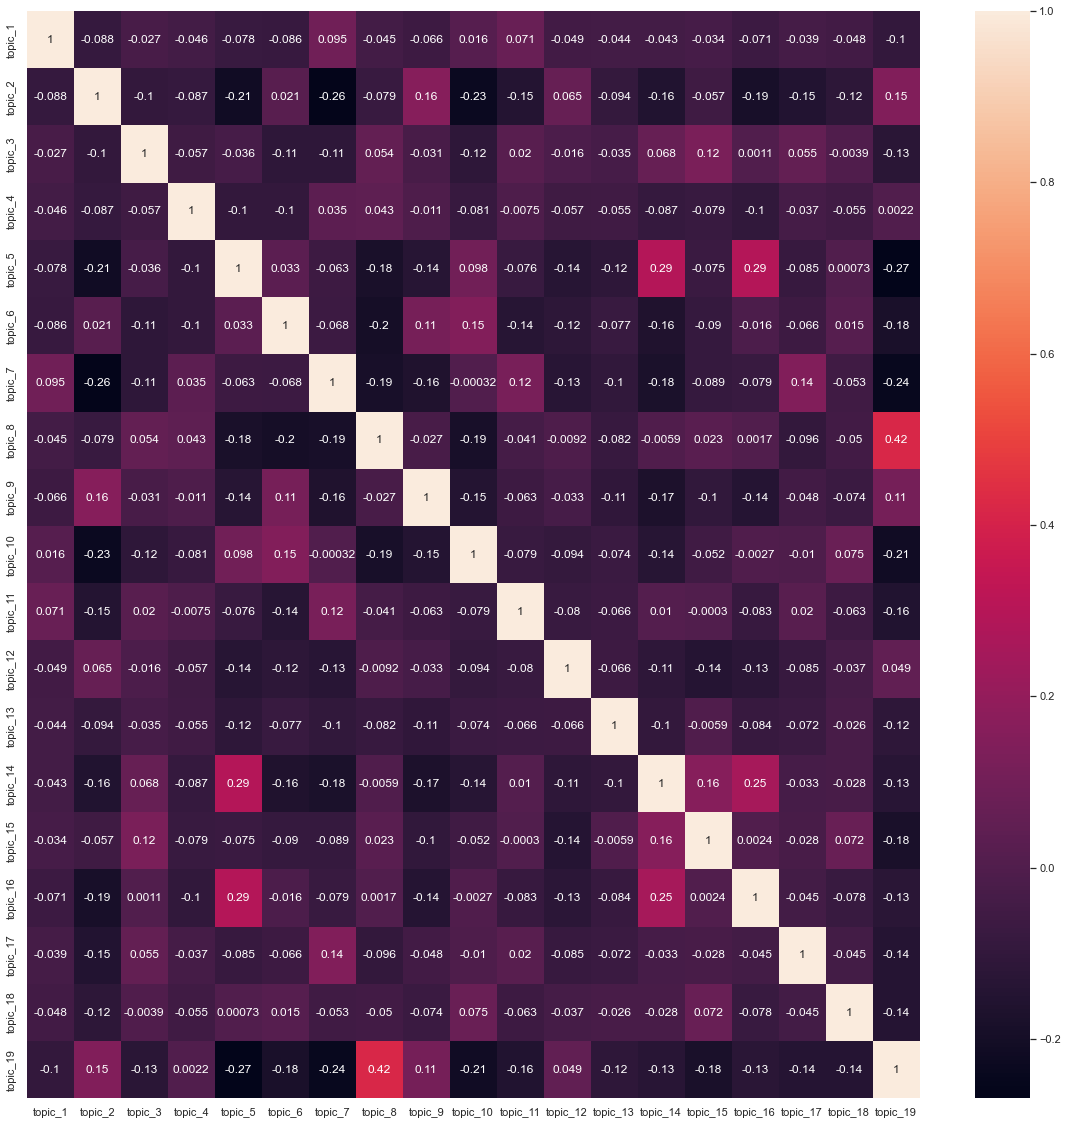

In [73]:
import seaborn as sns
# plot the corr
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(td.corr(), annot=True)

In [85]:
# td select the highest probability topic for each document
td_highest_prob = td.idxmax(axis=1)
model_df_MDQA['highest_prob'] = td_highest_prob
model_df_MDQA[model_df_MDQA['highest_prob']=='topic_2']

# Everest Re, Beazley PLC- LANCASHIRE HOLDI

,file_name,date,company_name,token,paraghrph,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,highest_prob
3,20110208_Beazley_PLC-_Earnings_Call_2011-2-8_S...,2011-02-08,Beazley PLC-,"[cushion, potential, turn, rightph, onph, fee,...",[ 2034501 No. Thank you. Just more specifical...,0.000171,0.368022,0.000683,0.012409,0.006922,0.100286,0.000252,0.003603,0.133405,0.000823,0.099893,0.003602,0.000261,0.012907,0.136569,0.045764,0.066889,0.000698,0.006840,topic_2
6,20110210_Everest_Re_Group_Ltd-_Earnings_Call_2...,2011-02-10,Everest Re,"[clarification, bucket, lumpiness, study, repd...",[ 6989856 Hi. Good morning. Just a clarificat...,0.000277,0.357011,0.015716,0.000604,0.050163,0.137962,0.000408,0.000962,0.001636,0.011072,0.000966,0.025309,0.083212,0.059849,0.001886,0.005889,0.001119,0.001130,0.244828,topic_2
7,20110221_LANCASHIRE_HOLDI-_Earnings_Call_2011-...,2011-02-21,LANCASHIRE HOLDI-,"[season, hint, decrease, withal, energy, attit...",[ 1941215 Two questions on my side. The first...,0.008776,0.661160,0.015006,0.000356,0.052536,0.012428,0.000241,0.014921,0.072733,0.000785,0.000570,0.060852,0.000249,0.000831,0.003983,0.009213,0.000659,0.006408,0.078294,topic_2
14,20110316_LANCASHIRE_HOLDI-_Shareholder_Mtg_Cal...,2011-03-16,LANCASHIRE HOLDI-,"[press, yesterday, attrition, erie, downtown, ...",[ 16852956 Great. Thanks. And my second quest...,0.000093,0.560849,0.072463,0.026418,0.002131,0.054607,0.000137,0.033092,0.080833,0.000448,0.031455,0.134674,0.000142,0.000474,0.000635,0.000343,0.000376,0.000380,0.000447,topic_2
18,20110428_Everest_Re_Group_Ltd-_Earnings_Call_2...,2011-04-28,Everest Re,"[picipation, remark, introduction, file, discl...","[Certainly. Thank you, ladies and gentlemen. T...",0.000194,0.585407,0.014361,0.000421,0.014611,0.001118,0.000285,0.014261,0.086077,0.024711,0.000674,0.031246,0.058051,0.000983,0.004713,0.000711,0.000780,0.014378,0.147017,topic_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,20210728_SCOR_SE-_Earnings_Call_2021-7-28_DN00...,2021-07-28,SCOR SE-,"[topic, color, math, deployment, color, picipa...","[ 15847584 Yeah. Thank you, and good afternoo...",0.000168,0.269077,0.000669,0.000365,0.133496,0.204305,0.000247,0.000582,0.201379,0.039116,0.000585,0.003528,0.000256,0.045057,0.012929,0.000617,0.015411,0.059622,0.012592,topic_2
1906,20210909_AMERICAN_INTERNA-_Conf-Presentation_C...,2021-09-09,AMERICAN INTERNA-,"[impression, therapy, remediation, effort, per...","[ 4281064 Okay, fantastic. Those tremendously...",0.000092,0.254405,0.097401,0.003435,0.006955,0.000532,0.000136,0.050454,0.189759,0.000442,0.011641,0.010022,0.003375,0.000468,0.184991,0.005190,0.000372,0.000375,0.179954,topic_2
1912,20210914_ARCH_CAPITAL_GRP-_Conf-Presentation_C...,2021-09-14,ARCH CAPITAL,"[scenario, inquencie, borrower, agreement, len...",[ 17410715 Yes. I think that's a very good qu...,0.000177,0.253030,0.034938,0.006610,0.016495,0.010360,0.000261,0.050406,0.200211,0.000851,0.044185,0.168659,0.000270,0.000901,0.035437,0.006875,0.106522,0.000722,0.063089,topic_2
1922,20211026_RENAISSANCERE-_Earnings_Call_2021-10-...,2021-10-26,RENAISSANCERE- Earnings,"[prospect, confice, confice, relationship, win...","[Thank you, everybody for your time. Our focus...",0.016298,0.409250,0.000459,0.000251,0.000608,0.006734,0.000170,0.000400,0.273771,0.006622,0.000401,0.022650,0.000176,0.051158,0.006852,0.002446,0.002488,0.051042,0.148224,topic_2


TypeError: 'tomotopy.LDAModel' object is not subscriptable

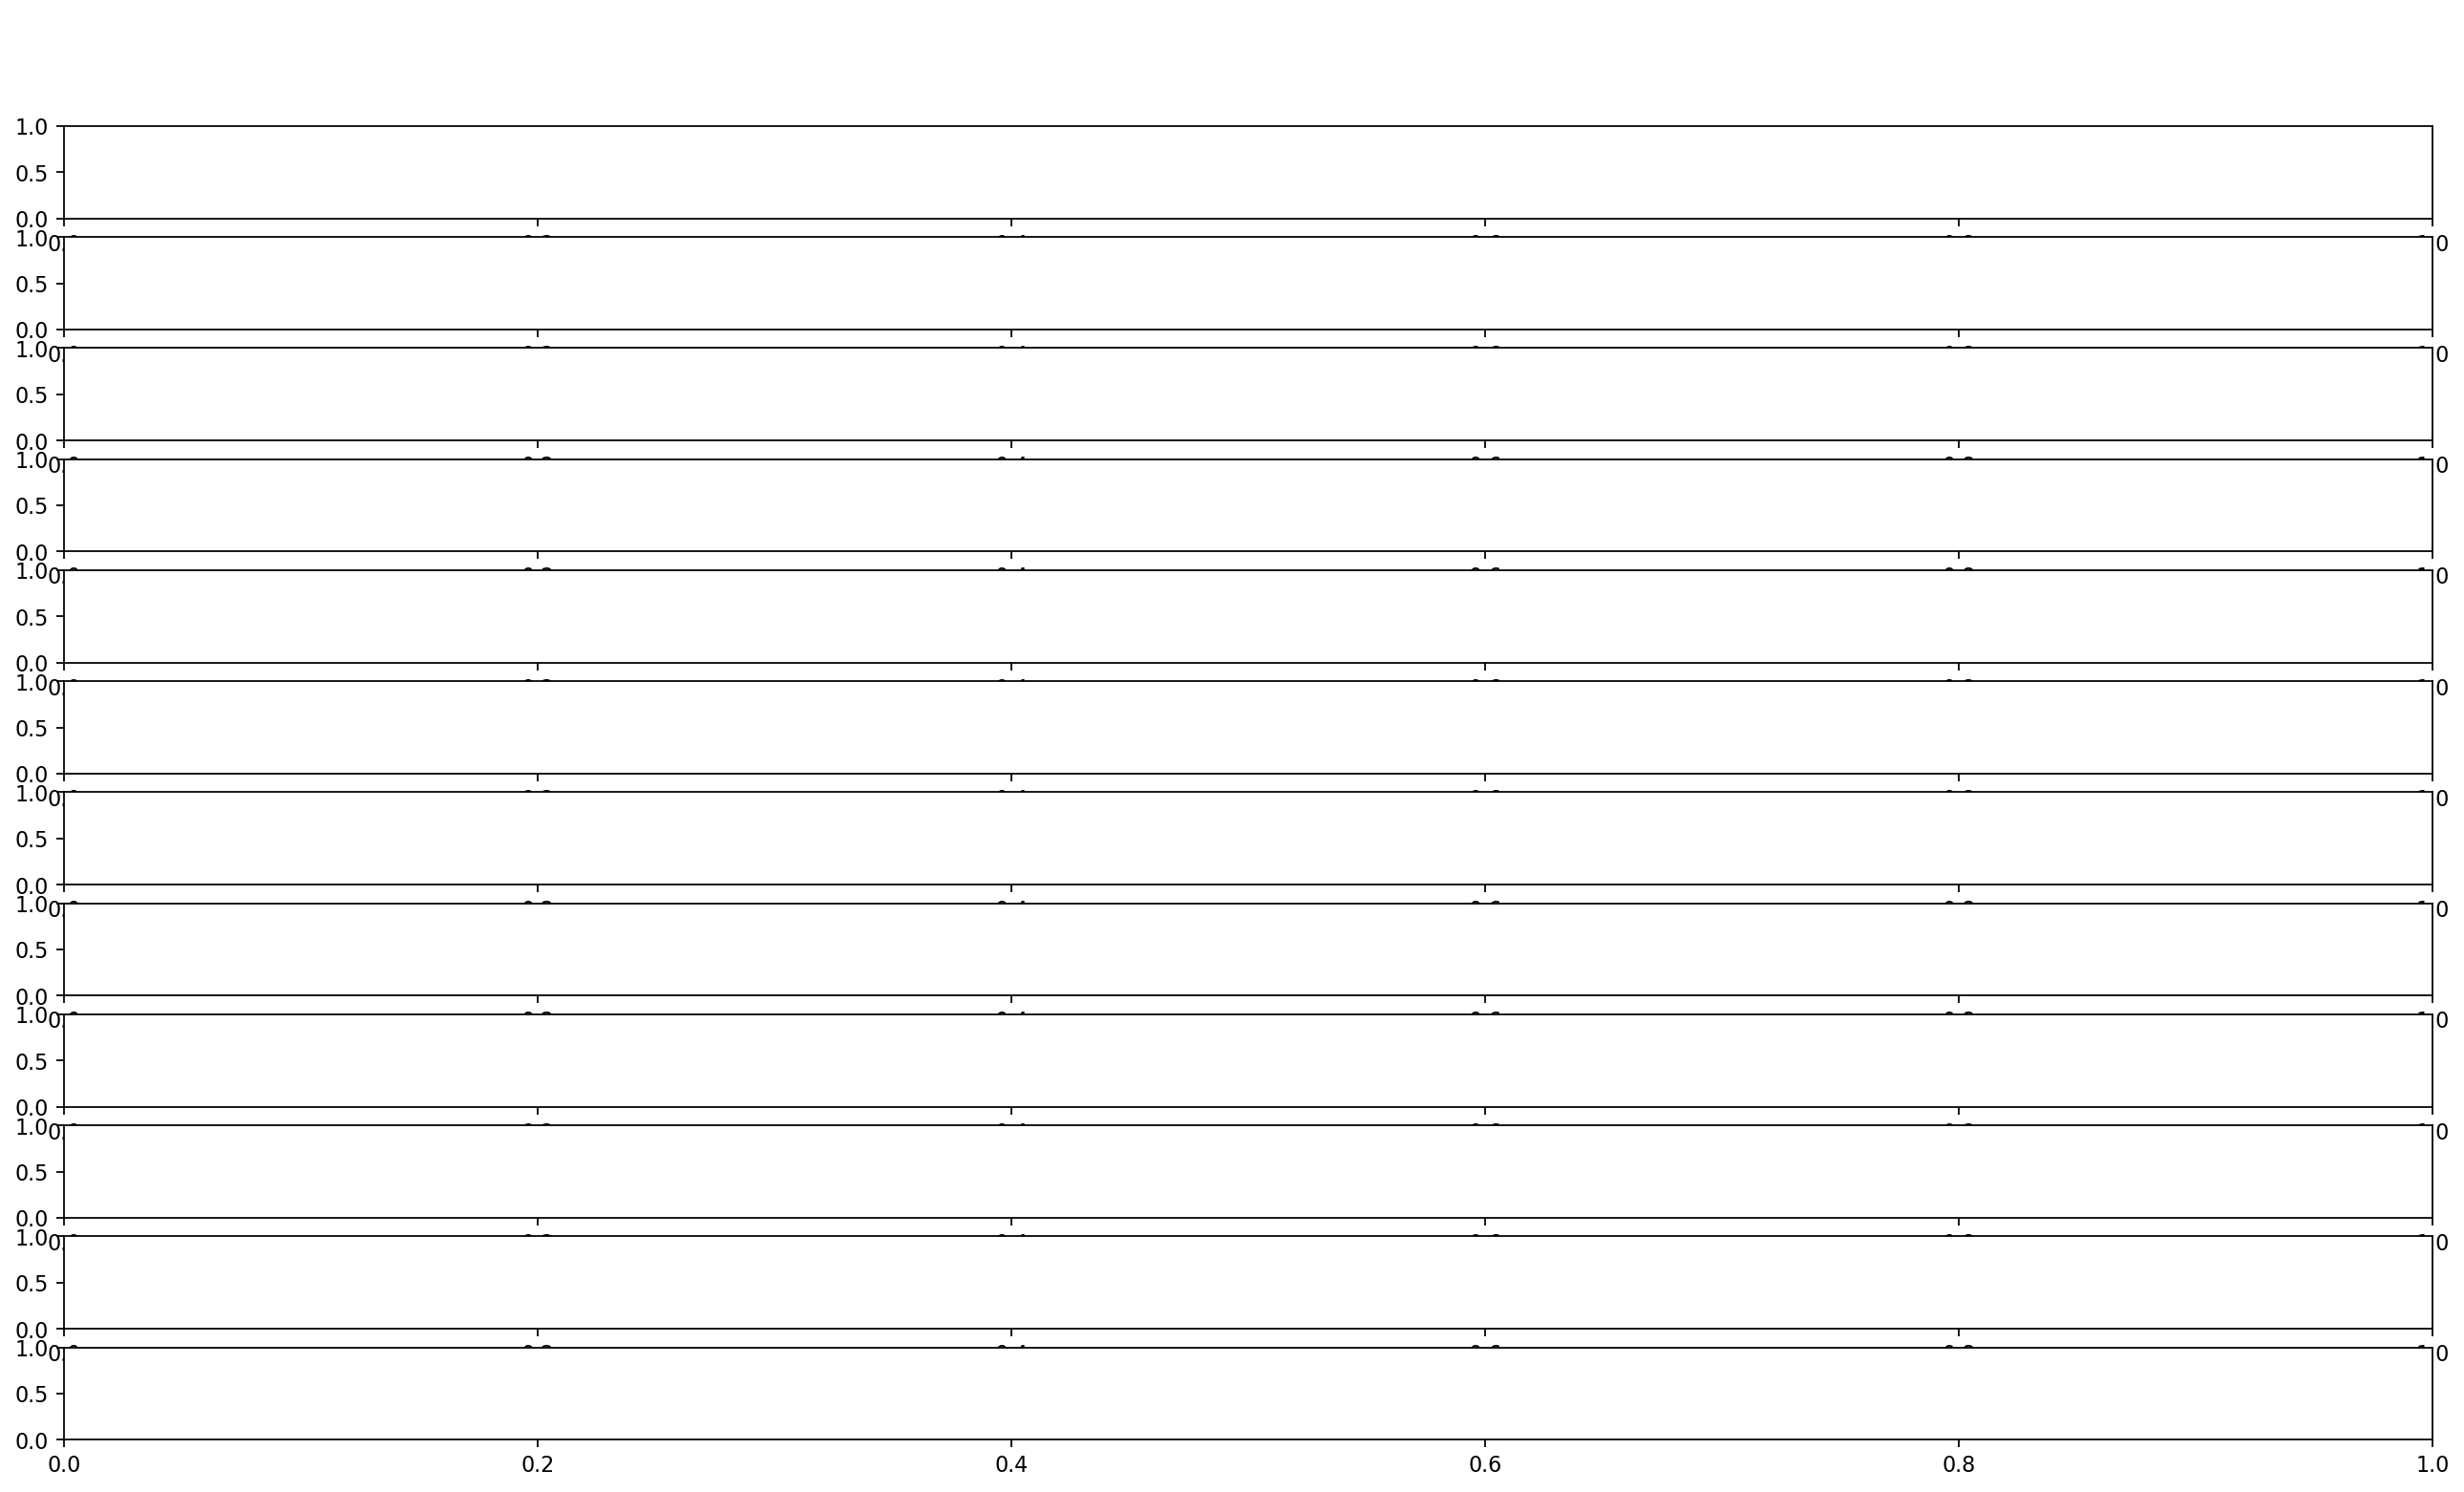

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
# plot the sentences_chart
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
for i in range(0, len(model_df_without_token)):
    ax.text(model_df_without_token.iloc[i]['highest_prob'], i, model_df_without_token.iloc[i]['sentence'], fontsize=10)
plt.xlabel('Topics')
plt.ylabel('Sentences')
plt.title('Sentences chart')
plt.show()


In [38]:
topic_percs

NameError: name 'topic_percs' is not defined